In [1]:
## Library Imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import imblearn as imbl
import xgboost as xgb
from hyperopt import hp, tpe, fmin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GroupKFold
from sklearn.metrics import plot_roc_curve, roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score


from pathlib import Path

## Custom libraries
import index_helpers as ih
import data_transformations as dtrans


## Importing, indexing and splitting

Set the parameters segmentation, fine_segmentation, exlude_expert, exclude_meta_data carefully

In [2]:
# Import, index, and split

## Setting the parameters
segmentation = True
fine_segmentation = True
exlude_expert=False
exclude_meta_data=False


df, _, _, _ = ih.read_and_merge_data(segmentation, fine_segmentation, exlude_expert, exclude_meta_data)
if segmentation:
    df, count = ih.index_df_by_person(df)
else:
    df = df.set_index(['File_Name'])
df = dtrans.low_var_exclusion(df, 0.1)

## Expert 2 labels removal
df = df[df["Expert"]!=2]

## Conversion into dummies of the 
df = pd.get_dummies(df, columns=['Resp_Condition', 'Gender', 'Expert'])

## Splitting into train/test and preparing groups for k-fold CV
if segmentation:
    X_train, X_test, y_train, y_test = ih.train_test_split_on_index(features = df.drop("Label", axis=1),
                                                            label = df["Label"])
    groups = y_train.reset_index()['File_Name_split']
else:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df.drop("Label", axis=1), df["Label"], test_size=0.2)
    groups = y_train.reset_index()['File_Name']

## Undersampling

In [3]:
X_t = X_train.reset_index(drop=False)
y_t = y_train.reset_index(drop=False)

In [4]:
from imblearn.over_sampling import RandomOverSampler
RUS = RandomOverSampler(random_state=42)
X_res, y_res = RUS.fit_resample(X_t, y_t["Label"])

df_res = X_res.merge(y_res, left_index=True, right_index=True)
if segmentation:
    df_res.set_index(['File_Name_split', 'File_n_recording'])
else:
    df_res.set_index(['File_Name'])

In [5]:
if segmentation:
    X = df_res.drop(columns=['File_Name_split', 'File_n_recording', 'Label'])
    y = df_res['Label']
    groups = df_res["File_Name_split"]
else:
    X = df_res.drop(columns=['File_Name', 'Label'])
    y = df_res['Label']
    groups = df_res["File_Name"]

### Bayesian Optimization

In [6]:
param_hyperopt = {'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1)),
                  'max_depth': hp.quniform('max_depth', 20, 100, 5),
                  'max_delta_step': hp.quniform('max_delta_step', 0, 20, 1),
                  'gamma': hp.uniform ('gamma', 1,9),
                  'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
                  'reg_lambda' : hp.uniform('reg_lambda', 0,1),
                  'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
                  'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
                  'n_estimators': hp.quniform('n_estimators', 50, 300, 10)}

def objective(params):
    
    ### Casting variables
    params = {'learning_rate': float(params['learning_rate']),
              'max_depth': int(params['max_depth']),
              'max_delta_step': int(params['max_delta_step']),
              'gamma': int(params['gamma']),
              'reg_alpha': int(params['reg_alpha']),
              'reg_lambda': float(params['reg_lambda']),
              'colsample_bytree': float(params['colsample_bytree']),
              'min_child_weight': int(params['min_child_weight']),
              'n_estimators': int(params['n_estimators'])}
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic',**params)
    
    gkf=GroupKFold(n_splits=5)
    best_score = cross_val_score(xgb_clf, X, y, cv=gkf, groups=groups, 
                                 scoring='roc_auc', n_jobs=-1).mean()
    
    return -best_score
    
best_result = fmin(fn=objective, space=param_hyperopt, max_evals=25, algo=tpe.suggest, rstate=np.random.RandomState(42))
best_result

100%|██████████| 25/25 [06:51<00:00, 16.45s/trial, best loss: -0.735713968703827] 


{'colsample_bytree': 0.5585532667489502,
 'gamma': 6.1301301864368005,
 'learning_rate': 0.013294175715252907,
 'max_delta_step': 8.0,
 'max_depth': 25.0,
 'min_child_weight': 2.0,
 'n_estimators': 300.0,
 'reg_alpha': 43.0,
 'reg_lambda': 0.7582701073262343}

In [7]:
best_result_cast = {'learning_rate': float(best_result['learning_rate']),
                  'max_depth': int(best_result['max_depth']),
                    'max_delta_step': int(best_result['max_delta_step']),
                  'gamma': int(best_result['gamma']),
                  'reg_alpha': int(best_result['reg_alpha']),
                  'reg_lambda': float(best_result['reg_lambda']),
                  'colsample_bytree': float(best_result['colsample_bytree']),
                  'min_child_weight': int(best_result['min_child_weight']),
                  'n_estimators': int(best_result['n_estimators'])}

## lets test
best_clf = xgb.XGBClassifier(objective='binary:logistic', **best_result_cast)

best_clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5585532667489502, gamma=6,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.013294175715252907, max_delta_step=8,
              max_depth=25, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=43,
              reg_lambda=0.7582701073262343, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
from sklearn.metrics import roc_auc_score
pred=best_clf.predict(X_test)
roc_auc_score(pred,y_test)

0.7197122294174118

## Plot ROC

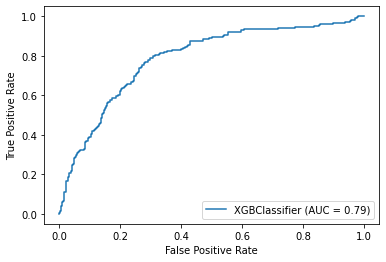

In [9]:
X_v = X_test.reset_index(drop=True)
y_v = y_test.reset_index(drop=True)

preds = best_clf.predict_proba(X_v)

plot_roc_curve(best_clf, X_v, y_v)

## XGBoost performance

Removing one expert at a time:
- Expert 3: AUC=0.72
- Expert 2: AUC=0.77
- Expert 1: AUC=0.73

Using ONLY ONE expert at a time:
- Expert 1: 0.57
- Expert 2: identical to random guess
- Expert 3: 0.53...

# SHAP values

In [10]:
!pip install shap

In [11]:
import shap  # package used to calculate Shap values


explainer = shap.KernelExplainer(best_clf.predict_proba, shap.kmeans(X_train, 50), link="logit")
shap_values = explainer.shap_values(X_v, nsamples=100)

Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=7.306e-06, with an active set of 34 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=7.269e-06, with an active set of 35 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=4.846e-06, with an active set of 37 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 54 iterations, alpha=5.175e-06, previous alpha=4.533e-06, with an active set of 37 regressors.
Regressors in active set degenerate. Dropping a regressor, after 50 

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_v)

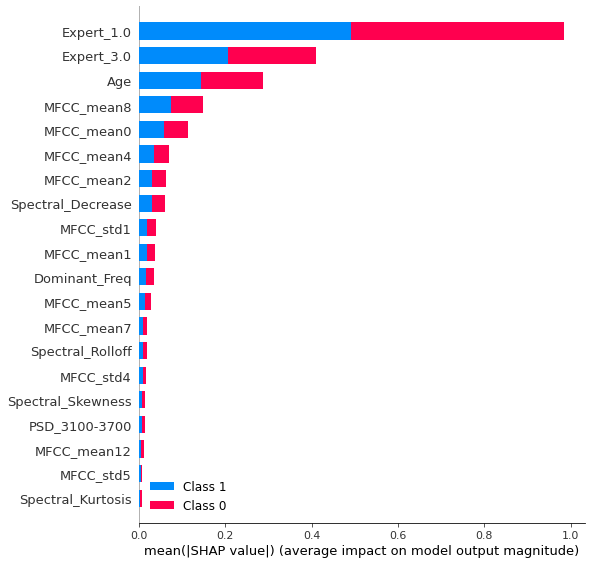

In [13]:
shap.summary_plot(shap_values, X_v)